In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn import preprocessing
import seaborn as sns
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
#loading the data
df=pd.read_csv("C:\\Users\\Lenovo\\Downloads\\Fraud_check.csv")
df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
df.columns=['u_grad','m_stat','t_inc','c_pop','w_exp','urban']
df.head()

,u_grad,m_stat,t_inc,c_pop,w_exp,urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [5]:
#binning the taxable income feature
bins=[0,30000,200000]
labels=['risky','good']
df['binned']=pd.cut(df['t_inc'],bins=bins,labels=labels)
df

,u_grad,m_stat,t_inc,c_pop,w_exp,urban,binned
0,NO,Single,68833,50047,10,YES,good
1,YES,Divorced,33700,134075,18,YES,good
2,NO,Married,36925,160205,30,YES,good
3,YES,Single,50190,193264,15,YES,good
4,NO,Married,81002,27533,28,NO,good
...,...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES,good
596,YES,Divorced,69967,55369,2,YES,good
597,NO,Divorced,47334,154058,0,YES,good
598,YES,Married,98592,180083,17,NO,good


In [6]:
#label encoding the categorical data
le=preprocessing.LabelEncoder()
df['u_grad']=le.fit_transform(df['u_grad'])
df['urban']=le.fit_transform(df['urban'])
df['m_stat']=le.fit_transform(df['m_stat'])
df['binned']=le.fit_transform(df['binned'])
df

,u_grad,m_stat,t_inc,c_pop,w_exp,urban,binned
0,0,2,68833,50047,10,1,0
1,1,0,33700,134075,18,1,0
2,0,1,36925,160205,30,1,0
3,1,2,50190,193264,15,1,0
4,0,1,81002,27533,28,0,0
...,...,...,...,...,...,...,...
595,1,0,76340,39492,7,1,0
596,1,0,69967,55369,2,1,0
597,0,0,47334,154058,0,1,0
598,1,1,98592,180083,17,0,0


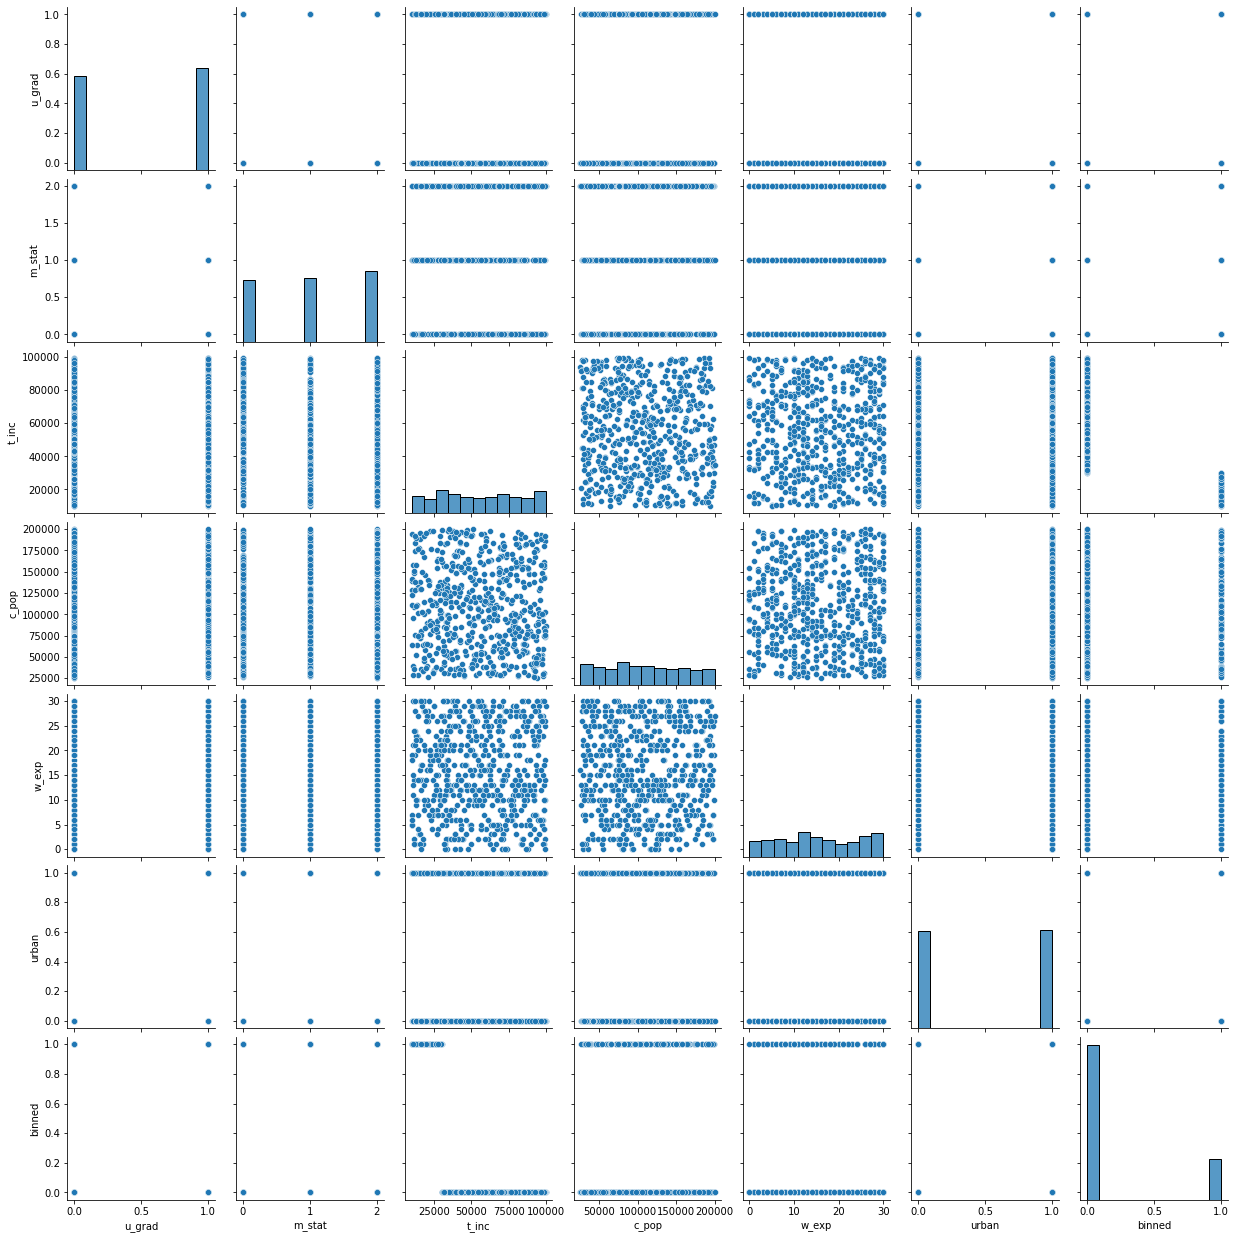

In [7]:
sns.pairplot(df)

In [8]:
df.corr()

,u_grad,m_stat,t_inc,c_pop,w_exp,urban,binned
u_grad,1.000000,0.042407,-0.049232,0.079579,-0.005362,-0.000267,0.012523
m_stat,0.042407,1.000000,-0.012944,-0.001564,-0.002213,0.064562,0.006081
t_inc,-0.049232,-0.012944,1.000000,-0.064387,-0.001818,0.070628,-0.688725
c_pop,0.079579,-0.001564,-0.064387,1.000000,0.013135,-0.040098,0.012225
w_exp,-0.005362,-0.002213,-0.001818,0.013135,1.000000,-0.094559,-0.001972
urban,-0.000267,0.064562,0.070628,-0.040098,-0.094559,1.000000,0.004830
binned,0.012523,0.006081,-0.688725,0.012225,-0.001972,0.004830,1.000000


In [9]:
#Normalizing numerical data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(df.loc[:,('t_inc','c_pop','w_exp')])
df.loc[:,('t_inc','c_pop','w_exp')]= scaler.transform(df.loc[:,('t_inc','c_pop','w_exp')])
df

,u_grad,m_stat,t_inc,c_pop,w_exp,urban,binned
0,0,2,0.656468,0.139472,0.333333,1,0
1,1,0,0.264428,0.622394,0.600000,1,0
2,0,1,0.300415,0.772568,1.000000,1,0
3,1,2,0.448436,0.962563,0.500000,1,0
4,0,1,0.792258,0.010081,0.933333,0,0
...,...,...,...,...,...,...,...
595,1,0,0.740236,0.078811,0.233333,1,0
596,1,0,0.669122,0.170058,0.066667,1,0
597,0,0,0.416566,0.737240,0.000000,1,0
598,1,1,0.988540,0.886810,0.566667,0,0


In [17]:
X=df.loc[:,('u_grad','m_stat','c_pop','w_exp','urban')]
Y=df.iloc[:,-1]

In [23]:
#building RF classifier model
num_trees = 100
max_features = 3
kfold = KFold(n_splits=15,shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.74
